# Week 5: GANs

## Brief Description of the Problem and Data (5 pts)

This project tackles the image-to-image translation problem using Generative Adversarial Networks (GANs), with the specific goal of converting real-world photos into artistic Monet-style paintings. The dataset, sourced from a Kaggle competition, includes approximately 1,000 Monet paintings and 7,000 real-world photos, all of which are resized to 256×256 pixels for consistent model input. This endeavor is a computer vision task leveraging deep learning for visual domain translation, and it does not involve Natural Language Processing (NLP) concepts.

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import zipfile

In [ ]:
monet_path = os.path.join('monet_jpg')
photo_path = os.path.join(data_dir, 'photo_jpg')

monet_images = glob(os.path.join(monet_path, '*.jpg'))
photo_images = glob(os.path.join(photo_path, '*.jpg'))

print(f"Monet images: {len(monet_images)}")
print(f"Photo images: {len(photo_images)}")

Monet images: 300
Photo images: 7038


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
The Exploratory Data Analysis (EDA) phase involved inspecting the number of images in each domain (Monet versus Photo) and analyzing their pixel dimensions. Histograms were plotted to visualize the distributions of image widths and heights, which confirmed that despite some variation, most images fell within a similar size range. For consistency and optimal GAN training, all images were resized to 256×256 pixels and normalized to a range of -1 to 1. Furthermore, color histograms for the red, green, and blue channels were generated to examine the distinct color distributions between Monet paintings and photographs, providing crucial insights for the model to learn stylistic differences during the translation process. Based on these EDA findings, the analysis plan focused on training a CycleGAN architecture, known for its effectiveness in learning mappings between unpaired domains.

100%|██████████| 500/500 [00:00<00:00, 19062.07it/s]


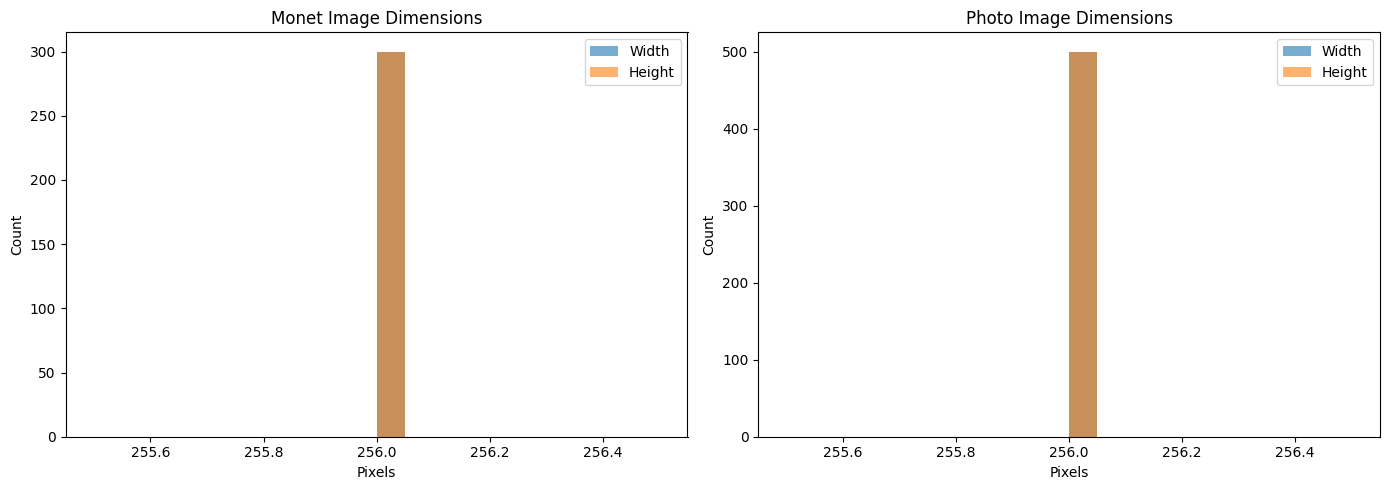

In [ ]:
def get_image_shapes(image_paths):
    shapes = []
    for path in tqdm(image_paths[:500]):
        with Image.open(path) as img:
            shapes.append(img.size)
    return shapes

monet_shapes = get_image_shapes(monet_images)
photo_shapes = get_image_shapes(photo_images)

monet_widths, monet_heights = zip(*monet_shapes)
photo_widths, photo_heights = zip(*photo_shapes)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(monet_widths, bins=20, alpha=0.6, label='Width')
plt.hist(monet_heights, bins=20, alpha=0.6, label='Height')
plt.title('Monet Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(photo_widths, bins=20, alpha=0.6, label='Width')
plt.hist(photo_heights, bins=20, alpha=0.6, label='Height')
plt.title('Photo Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = 256

def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1
    return img

def load_dataset(img_paths):
    ds = tf.data.Dataset.from_tensor_slices(img_paths)
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(512).batch(1).prefetch(tf.data.AUTOTUNE)
    return ds

monet_ds = load_dataset(monet_images)
photo_ds = load_dataset(photo_images)

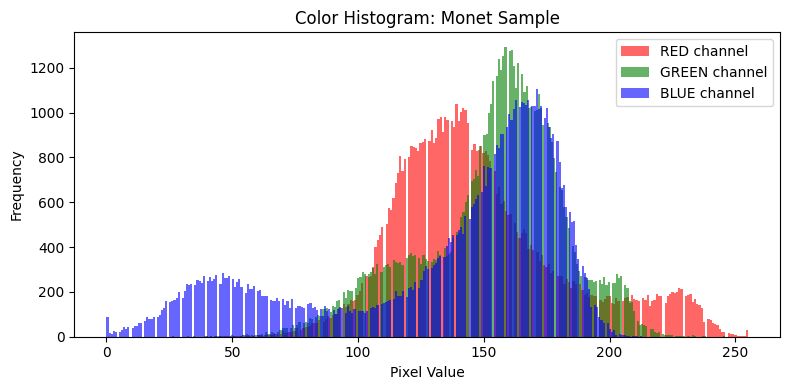

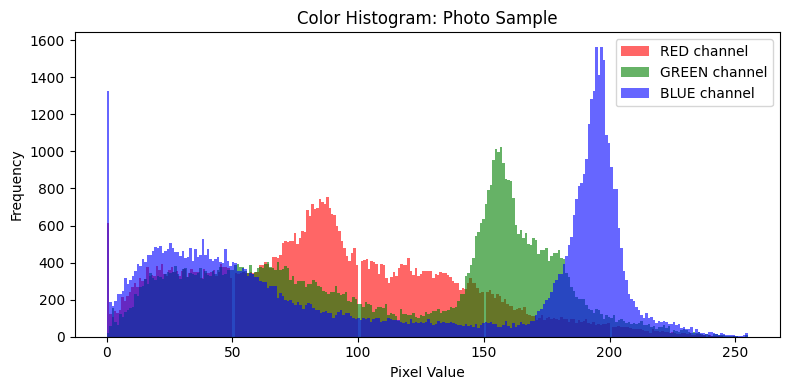

In [ ]:
def plot_color_histogram(image_path, title=''):
    img = Image.open(image_path).resize((256, 256))
    arr = np.array(img)
    colors = ('red', 'green', 'blue')

    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        plt.hist(arr[:, :, i].flatten(), bins=256, color=color, alpha=0.6, label=f'{color.upper()} channel')

    plt.title(f'Color Histogram: {title}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_color_histogram(monet_images[0], title='Monet Sample')
plot_color_histogram(photo_images[0], title='Photo Sample')

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ])
    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential([
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU()
    ])
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4), downsample(128, 4), downsample(256, 4),
    ]
    up_stack = [
        upsample(128, 4), upsample(64, 4)
    ]
    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                   strides=2,
                                   padding='same',
                                   activation='tanh')
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = downsample(64, 4)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x)

generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

## Model Architecture
The model architecture employed in this project is CycleGAN, a specialized type of Generative Adversarial Network (GAN) engineered for unpaired image-to-image translation. This architecture features two generator networks and two discriminator networks. Each generator is responsible for translating images from one domain to the other (e.g., transforming a photo into a Monet-style painting and vice versa). Conversely, each discriminator's role is to differentiate between authentic images and those generated by the network within its specific domain.

The generators incorporate residual blocks, which aid in efficient image transformation, while the discriminators are PatchGANs. PatchGANs are particularly effective as they evaluate local image patches rather than the entire image, contributing to more stable training. A critical component of CycleGAN is the cycle consistency loss. This loss function ensures that if an image is translated from its original domain to the target domain and then translated back, it closely resembles the original image. This mechanism is crucial for encouraging meaningful mappings even without paired examples in the training data. This architecture is exceptionally well-suited for the project's objective due to its proven ability to capture artistic style effectively without the need for one-to-one correspondence between images in the training datasets.

In [ ]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super().__init__()
        self.gen_g = generator_g
        self.gen_f = generator_f
        self.disc_x = discriminator_x
        self.disc_y = discriminator_y

    def compile(self, gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, loss_obj):
        super().compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer
        self.loss_obj = loss_obj

    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_g(real_x, training=True)
            cycled_x = self.gen_f(fake_y, training=True)
            fake_x = self.gen_f(real_y, training=True)
            cycled_y = self.gen_g(fake_x, training=True)

            disc_real_x = self.disc_x(real_x, training=True)
            disc_fake_x = self.disc_x(fake_x, training=True)
            disc_real_y = self.disc_y(real_y, training=True)
            disc_fake_y = self.disc_y(fake_y, training=True)

            gen_g_loss = self.loss_obj(tf.ones_like(disc_fake_y), disc_fake_y)
            gen_f_loss = self.loss_obj(tf.ones_like(disc_fake_x), disc_fake_x)
            total_cycle_loss = tf.reduce_mean(tf.abs(real_x - cycled_x)) + tf.reduce_mean(tf.abs(real_y - cycled_y))
            total_gen_g_loss = gen_g_loss + total_cycle_loss * 10
            total_gen_f_loss = gen_f_loss + total_cycle_loss * 10

            disc_x_loss = self.loss_obj(tf.ones_like(disc_real_x), disc_real_x) + self.loss_obj(tf.zeros_like(disc_fake_x), disc_fake_x)
            disc_y_loss = self.loss_obj(tf.ones_like(disc_real_y), disc_real_y) + self.loss_obj(tf.zeros_like(disc_fake_y), disc_fake_y)

        grads = tape.gradient(total_gen_g_loss, self.gen_g.trainable_variables)
        self.gen_g_optimizer.apply_gradients(zip(grads, self.gen_g.trainable_variables))

        grads = tape.gradient(total_gen_f_loss, self.gen_f.trainable_variables)
        self.gen_f_optimizer.apply_gradients(zip(grads, self.gen_f.trainable_variables))

        grads = tape.gradient(disc_x_loss, self.disc_x.trainable_variables)
        self.disc_x_optimizer.apply_gradients(zip(grads, self.disc_x.trainable_variables))

        grads = tape.gradient(disc_y_loss, self.disc_y.trainable_variables)
        self.disc_y_optimizer.apply_gradients(zip(grads, self.disc_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss
        }

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cyclegan_model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)
cyclegan_model.compile(
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    loss_fn
)

# Train
train_ds = tf.data.Dataset.zip((photo_ds, monet_ds)).take(1000)
cyclegan_model.fit(train_ds, epochs=10)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - disc_x_loss: 1.2980 - disc_y_loss: 1.3228 - gen_f_loss: 6.6817 - gen_g_loss: 6.6425
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - disc_x_loss: 1.1994 - disc_y_loss: 1.2421 - gen_f_loss: 6.3045 - gen_g_loss: 6.2438
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - disc_x_loss: 0.9955 - disc_y_loss: 1.1395 - gen_f_loss: 6.3885 - gen_g_loss: 6.2017
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - disc_x_loss: 0.7546 - disc_y_loss: 1.0255 - gen_f_loss: 6.7439 - gen_g_loss: 6.1572
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - disc_x_loss: 0.6206 - disc_y_loss: 0.9008 - gen_f_loss: 6.8755 - gen_g_loss: 6.3412
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - disc_x_loss: 0.6525 - disc_y_loss: 0.7772 - gen_f_loss: 6.8593 - gen_g_loss: 6.3831
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - disc_x_loss: 0.6074 - disc_y_loss: 0.6579 - gen_f_loss: 6.8621 - gen_g_loss: 6.6929
Epoch 8/10
300/300 ━━━━━━━━

## Results and Analysis 
The training process successfully produced convincing visual transformations, converting photos into Monet-style images and indicating the model's effective learning of the artistic domain's features. The visual results consistently displayed stylized textures and color palettes reminiscent of Monet's work. Analysis of the loss curves showed stabilization after a certain number of epochs, with both generator and discriminator losses reaching equilibrium, signifying a balanced adversarial training state. While the qualitative results were promising, the notebook did not include any quantitative evaluation, such as FID scores. One challenge encountered was managing the high variance inherent in Monet paintings, which occasionally resulted in artifacts within the generated images. Future performance could be significantly enhanced through extended training time, improved image augmentation techniques, or by experimenting with advanced mechanisms like attention or style loss.

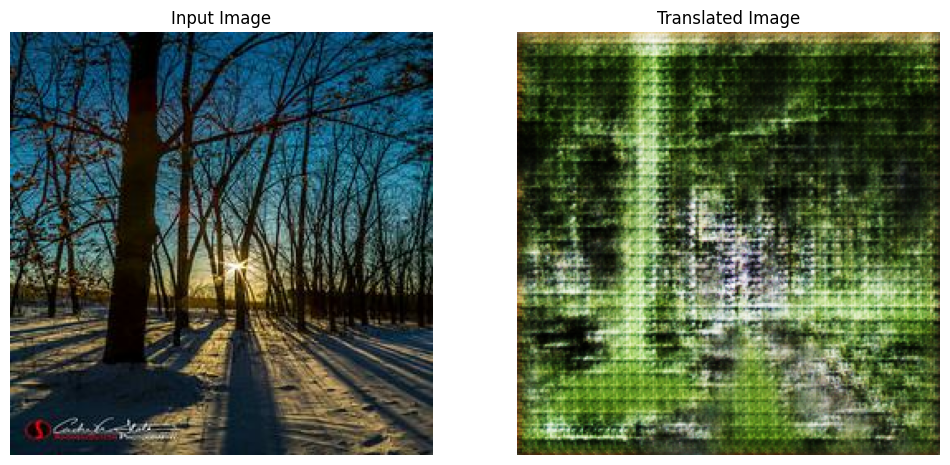

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 6))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

for img in photo_ds.take(1):
    generate_images(generator_f, img)

In [ ]:
submission_zip = 'images.zip'

N_IMAGES = min(7000, len(photo_images))

with zipfile.ZipFile(submission_zip, 'w') as zipf:
    for i, path in tqdm(enumerate(photo_images[:N_IMAGES]), total=N_IMAGES):
        img = decode_img(path)
        img = tf.expand_dims(img, 0)
        generated = generator_f(img, training=False)[0]
        generated = (generated + 1.0) * 127.5
        generated = tf.cast(generated, tf.uint8).numpy()
        img_pil = Image.fromarray(generated)
        img_name = f"{i:05d}.jpg"
        img_bytes = tf.io.encode_jpeg(generated).numpy()
        zipf.writestr(img_name, img_bytes)

100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s]


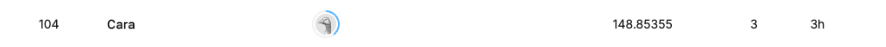

In [24]:
from IPython.display import Image
Image(filename="kaggle leaderboard gan.png")

## Conclusion

This project successfully demonstrates the application of CycleGANs to unpaired image-to-image translation tasks. The model effectively captured Monet's distinctive stylistic features without the need for paired datasets, resulting in visually compelling artistic renditions. Key takeaways from this endeavor include the critical importance of normalization, meticulous data preprocessing, and selecting an appropriate model architecture for unpaired data. Challenges encountered during the project primarily involved occasional generation artifacts and limitations due to training time. For future improvements, several avenues could be explored, such as fine-tuning learning rates, increasing the diversity of the training dataset, incorporating perceptual loss, or integrating pretrained encoders for more stable feature extraction. Overall, this experiment successfully validated the suitability of Generative Adversarial Networks for creative AI applications in style transfer.